In [228]:
from dataclasses import dataclass
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import numpy as np 
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from torchfuzzy.fuzzy_layer import FuzzyLayer

In [213]:
batch_size = 256
learning_rate = 2e-3
weight_decay = 1e-2
num_epochs = 50
latent_dim = 6
output_dims = 2
beta = 1
gamma = 1 
fuzzy_labels = 10 #10 numbers 
unknown_classes_ratio = 0.0 # unknow samples rate
is_fuzzy_loss_active = True
is_fuzzy_cvae = True

prefix = "vae"
if is_fuzzy_loss_active:
    prefix = f"fuzzy_cvae_with_unknown_ratio_{unknown_classes_ratio}"
writer = SummaryWriter(f'runs/mnist/{prefix}_{datetime.now().strftime("%Y%m%d-%H%M%S")}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if is_fuzzy_loss_active:
    gamma = 1
else:
    gamma = 0

In [214]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.view(-1, 28, 28) - 0.5),
])

In [215]:
def get_target_and_mask(target_label, unknown_ratio):
    """
    Возвращает вектор целевого значения и маску в виде сдвоенного тензора

    Args:
        target_label (int): Метка класса
        unknown_ratio (float): Доля примеров в датасете, чья разметка будет игнорироваться при обучении
    
    Returns:
        tensor (2, 12)
    """
    t = F.one_hot(torch.LongTensor([target_label]), fuzzy_labels)
    m = torch.ones((1, fuzzy_labels)) if torch.rand(1) > unknown_ratio else torch.zeros((1, fuzzy_labels))
    
    return torch.cat((t, m), 0).to(device) 

In [216]:
# загружаем обучающую выборку
train_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=True, 
    transform = transform,
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x,unknown_classes_ratio))
)

In [217]:
# загружаем тестовую выборку
test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=False, 
    transform=transform, 
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x, 0))
)
len(test_data)

10000

In [218]:
# Создаем итераторы датасетов
train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True,
    
)
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
)

In [219]:
class Encoder(nn.Module):
    """
    Компонент энкодера для VAE
    
    Args:
        latent_dim (int): Размер латентного вектора.
    """
    
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
                
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5),
            nn.SiLU(),  
            nn.Conv2d(8, 16, kernel_size=5),
            nn.SiLU(),  
            nn.Conv2d(16, 32, kernel_size=5),
            nn.SiLU(),  
            nn.Conv2d(32, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.SiLU(),  
            nn.Flatten(),
            nn.Linear(9216, 625),
            nn.BatchNorm1d(625),
            nn.SiLU(),  
            nn.Linear(625, 2 * latent_dim), # mean + variance.
        )
        self.softplus = nn.Softplus()
         
    def forward(self, x, eps: float = 1e-8):
        """
        Выход энкодера для чистого VAE.
        
        Args:
            x (torch.Tensor): Входной вектор.
            eps (float): Небольшая поправка к скейлу для лучшей сходимости и устойчивости.
        
        Returns:
            mu, logvar, z, dist
        """

        x = self.encoder(x)
        mu, logvar = torch.chunk(x, 2, dim=-1)
        scale = self.softplus(logvar) + eps
        scale_tril = torch.diag_embed(scale)
        dist = torch.distributions.MultivariateNormal(mu, scale_tril=scale_tril)
        z = dist.rsample()

        return mu, logvar, z

In [220]:
class Decoder(nn.Module):
    """
    Компонент декодера для VAE
    
    Args:
        latent_dim (int): Размер латентного вектора.
    """
    
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
                
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 625),
            nn.BatchNorm1d(625),
            nn.SiLU(), 
            nn.Linear(625, 9216),
            nn.BatchNorm1d(9216),
            nn.SiLU(), 
            nn.Unflatten(1,(64, 12, 12)),
            nn.ConvTranspose2d(64, 32, 5),
            nn.SiLU(), 
            nn.ConvTranspose2d(32, 16, 5),
            nn.SiLU(), 
            nn.ConvTranspose2d(16, 8, 5),
            nn.SiLU(), 
            nn.ConvTranspose2d(8, 1, 5),
            nn.Sigmoid() 
        )
         
    def forward(self, z):
        """
        Декодирует латентный вектор в исходное представление
        
        Args:
            z (torch.Tensor): Латентный вектор.
        
        Returns:
            x
        """

        x = self.decoder(z)
        
        return x

In [221]:
class CVAE(nn.Module):
    """
    Conditional Variational Autoencoder (C-VAE) 
    
    Args:
        latent_dim (int): Размер латентного вектора.
        labels_count (int): Количество выходов классификатора
    """
    def __init__(self, latent_dim, labels_count, output_dims, fuzzy):
        super(CVAE, self).__init__()

        self.encoder = Encoder(latent_dim)        
        self.decoder = Decoder(latent_dim)
        self.output_dims = output_dims
        
        if fuzzy:
            self.output = nn.Sequential(
                FuzzyLayer.fromdimentions(output_dims, labels_count, trainable=True)
            )
        else:
            self.output = nn.Sequential(
                nn.Linear(output_dims, labels_count),
                nn.Sigmoid(),
                nn.Linear(labels_count, labels_count),
                nn.Sigmoid()
            )
        
        
    def forward(self, x):
        """
        Возвращает компоненты внутренних слоев CVAE, результаты реконструкции и классификации
        
        Args:
            x (torch.Tensor): Входной вектор.
        
        Returns:
            mu, x_recon, labels
        """

        mu, _,  _, = self.encoder(x)
        x_recon = self.decoder(mu)
        
        labels = self.output(mu[:, :self.output_dims])

        return mu, x_recon, labels
    
    def half_pass(self, x):
        """
        Возвращает результаты работы энкодера и классификатора
        """
        mu, logvar, z = self.encoder(x)
        labels = self.output(mu[:, :self.output_dims])

        return mu, logvar, z, labels
    
    def decoder_pass(self, x):
        return self.decoder(x)


In [222]:
def compute_loss(x, recon_x, mu, logvar, z, target_labels, predicted_labels):
    
    loss_recon = F.binary_cross_entropy(recon_x, x + 0.5, reduction='none').sum(-1).mean()
    
    tsquare = torch.square(mu)
    tlogvar = torch.exp(logvar)
    kl_loss = -0.5 * (1 + logvar - tsquare - tlogvar)
    loss_kl = kl_loss.sum(-1).mean()
            
    target_firings = target_labels[:,0,:]
    mask = target_labels[:,1,:]
    loss_fuzzy = (mask * torch.square(target_firings - predicted_labels)).sum(-1).mean()

    loss = loss_recon + beta * loss_kl + gamma * loss_fuzzy

    

    return loss, loss_recon, loss_kl, loss_fuzzy
    

In [223]:
model = CVAE(latent_dim=latent_dim, labels_count=fuzzy_labels, output_dims=output_dims, fuzzy=is_fuzzy_cvae).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')

model

Number of parameters: 11,697,825


CVAE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
      (1): SiLU()
      (2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
      (3): SiLU()
      (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
      (5): SiLU()
      (6): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): SiLU()
      (9): Flatten(start_dim=1, end_dim=-1)
      (10): Linear(in_features=9216, out_features=625, bias=True)
      (11): BatchNorm1d(625, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): SiLU()
      (13): Linear(in_features=625, out_features=12, bias=True)
    )
    (softplus): Softplus(beta=1.0, threshold=20.0)
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=6, out_features=625, bias=True)
      (1): BatchNorm1d(625, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [224]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [225]:
def train(model, dataloader, optimizer, prev_updates, writer=None):
    model.train()  
    
    for batch_idx, (data, target) in enumerate(tqdm(dataloader)):
        n_upd = prev_updates + batch_idx
        
        data = data.to(device)
        
        optimizer.zero_grad()  
        
        mu, logcar, z, labels = model.half_pass(data)  
        recon_x = model.decoder_pass(z)
        loss, loss_recon, loss_kl, loss_fuzzy = compute_loss(data, recon_x, mu, logcar, z, target, labels)
        
        loss.backward()
        
        if n_upd % 100 == 0:
            total_norm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** (1. / 2)
        
            print(f'Step {n_upd:,} (N samples: {n_upd*batch_size:,}), Loss: {loss.item():.4f} (Recon: {loss_recon.item():.4f}, KL: {loss_kl.item():.4f} Fuzzy: {loss_fuzzy.item():.4f}) Grad: {total_norm:.4f}')

            if writer is not None:
                global_step = n_upd
                writer.add_scalar('Loss/Train', loss.item(), global_step)
                writer.add_scalar('Loss/Train/BCE', loss_recon.item(), global_step)
                writer.add_scalar('Loss/Train/KLD', loss_kl.item(), global_step)
                writer.add_scalar('Fuzzy/Train/Loss', loss_fuzzy.item(), global_step)
                writer.add_scalar('GradNorm/Train', total_norm, global_step)
            
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)    
        
        optimizer.step()  
        
    return prev_updates + len(dataloader)

In [226]:
def test(model, dataloader, cur_step, writer=None):
    model.eval() 
    test_loss = 0
    test_recon_loss = 0
    test_kl_loss = 0
    test_fuzzy_loss = 0
    test_accuracy = 0
    
    with torch.no_grad():
        for data, target in tqdm(dataloader, desc='Testing'):
            data = data.to(device)
            mu, logcar, z, labels = model.half_pass(data)  
            recon_x = model.decoder_pass(z)
            loss, loss_recon, loss_kl, loss_fuzzy = compute_loss(data, recon_x, mu, logcar, z,  target, labels)
            
            test_loss += loss.item()
            test_recon_loss += loss_recon.item()
            test_kl_loss += loss_kl.item()
            test_fuzzy_loss += loss_fuzzy.item()
            pred_target = np.argmax(labels[:, 0:10].cpu().numpy(), axis=1)
            target_labels =  np.argmax(target[:,0, 0:10].cpu().numpy(), axis=1)
            test_accuracy += np.sum(target_labels==pred_target) / len(pred_target)

    test_loss /= len(dataloader)
    test_recon_loss /= len(dataloader)
    test_kl_loss /= len(dataloader)
    test_fuzzy_loss /= len(dataloader)
    test_accuracy /= len(dataloader)

    print(f'====> Test set loss: {test_loss:.4f} (BCE: {test_recon_loss:.4f}, KLD: {test_kl_loss:.4f} Fuzzy: {test_fuzzy_loss:.4f} Accuracy {test_accuracy:.4f})')
    
    if writer is not None:
        writer.add_scalar('Loss/Test', test_loss, global_step=cur_step)
        writer.add_scalar('Loss/Test/BCE', loss_recon.item(), global_step=cur_step)
        writer.add_scalar('Loss/Test/KLD', loss_kl.item(), global_step=cur_step)
        writer.add_scalar('Fuzzy/Test/Loss', loss_fuzzy.item(), global_step=cur_step)
        writer.add_scalar('Fuzzy/Test/Accuracy', test_accuracy, global_step=cur_step)
        
        z = torch.randn(16, latent_dim).to(device)
        samples = model.decoder_pass(z)
        writer.add_images('Test/Samples', samples.view(-1, 1, 28, 28), global_step=cur_step)

In [227]:
prev_updates = 0
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    prev_updates = train(model, train_loader, optimizer, prev_updates, writer=writer)
    test(model, test_loader, prev_updates, writer=writer)


Epoch 1/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 0 (N samples: 0), Loss: 22.2078 (Recon: 20.2764, KL: 0.5270 Fuzzy: 1.4044) Grad: 17.0575
Step 100 (N samples: 25,600), Loss: 8.5128 (Recon: 7.1606, KL: 0.4607 Fuzzy: 0.8915) Grad: 8.0661
Step 200 (N samples: 51,200), Loss: 7.9648 (Recon: 6.4774, KL: 0.8048 Fuzzy: 0.6826) Grad: 13.5088


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 8.2156 (BCE: 6.3059, KLD: 1.2245 Fuzzy: 0.6852 Accuracy 0.5283)
Epoch 2/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 300 (N samples: 76,800), Loss: 7.9600 (Recon: 6.2938, KL: 0.9966 Fuzzy: 0.6696) Grad: 15.9806
Step 400 (N samples: 102,400), Loss: 7.8161 (Recon: 6.1252, KL: 1.1469 Fuzzy: 0.5440) Grad: 3.5143


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.6528 (BCE: 6.0735, KLD: 1.0304 Fuzzy: 0.5489 Accuracy 0.6688)
Epoch 3/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 500 (N samples: 128,000), Loss: 7.5865 (Recon: 5.8931, KL: 1.1659 Fuzzy: 0.5275) Grad: 3.0737
Step 600 (N samples: 153,600), Loss: 7.4505 (Recon: 5.8364, KL: 1.1463 Fuzzy: 0.4678) Grad: 3.8004
Step 700 (N samples: 179,200), Loss: 7.5824 (Recon: 6.0073, KL: 1.1238 Fuzzy: 0.4513) Grad: 3.4350


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.4971 (BCE: 5.9361, KLD: 1.1557 Fuzzy: 0.4053 Accuracy 0.7510)
Epoch 4/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 800 (N samples: 204,800), Loss: 7.3454 (Recon: 5.7951, KL: 1.1795 Fuzzy: 0.3708) Grad: 2.5739
Step 900 (N samples: 230,400), Loss: 7.3033 (Recon: 5.7241, KL: 1.2043 Fuzzy: 0.3749) Grad: 3.7509


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3875 (BCE: 5.8425, KLD: 1.1907 Fuzzy: 0.3542 Accuracy 0.7957)
Epoch 5/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,000 (N samples: 256,000), Loss: 7.5528 (Recon: 5.9857, KL: 1.2124 Fuzzy: 0.3547) Grad: 2.8534
Step 1,100 (N samples: 281,600), Loss: 7.3792 (Recon: 5.8562, KL: 1.1960 Fuzzy: 0.3270) Grad: 3.3886


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3397 (BCE: 5.7114, KLD: 1.3515 Fuzzy: 0.2768 Accuracy 0.8563)
Epoch 6/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,200 (N samples: 307,200), Loss: 7.3691 (Recon: 5.8665, KL: 1.2368 Fuzzy: 0.2658) Grad: 1.5201
Step 1,300 (N samples: 332,800), Loss: 7.4657 (Recon: 5.9243, KL: 1.2495 Fuzzy: 0.2919) Grad: 2.8331
Step 1,400 (N samples: 358,400), Loss: 7.0680 (Recon: 5.5854, KL: 1.2172 Fuzzy: 0.2654) Grad: 2.5860


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2997 (BCE: 5.7614, KLD: 1.2843 Fuzzy: 0.2541 Accuracy 0.8951)
Epoch 7/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,500 (N samples: 384,000), Loss: 7.2433 (Recon: 5.7437, KL: 1.2465 Fuzzy: 0.2531) Grad: 2.4724
Step 1,600 (N samples: 409,600), Loss: 7.3886 (Recon: 5.8810, KL: 1.2646 Fuzzy: 0.2429) Grad: 1.7327


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2263 (BCE: 5.7529, KLD: 1.2414 Fuzzy: 0.2321 Accuracy 0.9431)
Epoch 8/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,700 (N samples: 435,200), Loss: 7.0595 (Recon: 5.6015, KL: 1.2492 Fuzzy: 0.2088) Grad: 2.3886
Step 1,800 (N samples: 460,800), Loss: 7.3046 (Recon: 5.8498, KL: 1.2563 Fuzzy: 0.1985) Grad: 2.8883


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1977 (BCE: 5.7132, KLD: 1.2948 Fuzzy: 0.1897 Accuracy 0.9479)
Epoch 9/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,900 (N samples: 486,400), Loss: 7.3724 (Recon: 5.9343, KL: 1.2078 Fuzzy: 0.2304) Grad: 2.9346
Step 2,000 (N samples: 512,000), Loss: 7.2326 (Recon: 5.7819, KL: 1.2631 Fuzzy: 0.1876) Grad: 2.0857
Step 2,100 (N samples: 537,600), Loss: 7.2363 (Recon: 5.7747, KL: 1.2652 Fuzzy: 0.1964) Grad: 1.7161


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1646 (BCE: 5.7223, KLD: 1.2740 Fuzzy: 0.1684 Accuracy 0.9545)
Epoch 10/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 2,200 (N samples: 563,200), Loss: 7.1763 (Recon: 5.7591, KL: 1.2614 Fuzzy: 0.1559) Grad: 2.8862
Step 2,300 (N samples: 588,800), Loss: 6.9696 (Recon: 5.5396, KL: 1.2559 Fuzzy: 0.1740) Grad: 1.9715


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1564 (BCE: 5.6818, KLD: 1.3061 Fuzzy: 0.1685 Accuracy 0.9595)
Epoch 11/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 2,400 (N samples: 614,400), Loss: 7.2154 (Recon: 5.7735, KL: 1.2668 Fuzzy: 0.1751) Grad: 2.4477
Step 2,500 (N samples: 640,000), Loss: 7.1761 (Recon: 5.7351, KL: 1.2451 Fuzzy: 0.1959) Grad: 1.9777


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1265 (BCE: 5.7165, KLD: 1.2529 Fuzzy: 0.1572 Accuracy 0.9653)
Epoch 12/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 2,600 (N samples: 665,600), Loss: 7.2120 (Recon: 5.8098, KL: 1.2549 Fuzzy: 0.1473) Grad: 2.3642
Step 2,700 (N samples: 691,200), Loss: 7.1523 (Recon: 5.7075, KL: 1.2743 Fuzzy: 0.1704) Grad: 2.4597
Step 2,800 (N samples: 716,800), Loss: 7.1279 (Recon: 5.7086, KL: 1.2495 Fuzzy: 0.1698) Grad: 1.8167


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0978 (BCE: 5.6777, KLD: 1.2662 Fuzzy: 0.1539 Accuracy 0.9653)
Epoch 13/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 2,900 (N samples: 742,400), Loss: 7.3022 (Recon: 5.9271, KL: 1.2311 Fuzzy: 0.1440) Grad: 2.2944
Step 3,000 (N samples: 768,000), Loss: 7.2187 (Recon: 5.7897, KL: 1.2951 Fuzzy: 0.1339) Grad: 1.8045


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0951 (BCE: 5.7024, KLD: 1.2453 Fuzzy: 0.1474 Accuracy 0.9675)
Epoch 14/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 3,100 (N samples: 793,600), Loss: 7.2979 (Recon: 5.8463, KL: 1.2542 Fuzzy: 0.1974) Grad: 2.4533
Step 3,200 (N samples: 819,200), Loss: 6.8761 (Recon: 5.4673, KL: 1.2857 Fuzzy: 0.1232) Grad: 1.8766


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1018 (BCE: 5.7473, KLD: 1.2310 Fuzzy: 0.1235 Accuracy 0.9730)
Epoch 15/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 3,300 (N samples: 844,800), Loss: 7.0288 (Recon: 5.6316, KL: 1.2435 Fuzzy: 0.1536) Grad: 2.1918
Step 3,400 (N samples: 870,400), Loss: 6.9129 (Recon: 5.5491, KL: 1.2421 Fuzzy: 0.1218) Grad: 1.7553
Step 3,500 (N samples: 896,000), Loss: 7.0606 (Recon: 5.6186, KL: 1.2798 Fuzzy: 0.1622) Grad: 2.8907


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0844 (BCE: 5.6748, KLD: 1.2731 Fuzzy: 0.1364 Accuracy 0.9713)
Epoch 16/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 3,600 (N samples: 921,600), Loss: 7.1883 (Recon: 5.7657, KL: 1.2808 Fuzzy: 0.1417) Grad: 1.7027
Step 3,700 (N samples: 947,200), Loss: 7.1305 (Recon: 5.7245, KL: 1.2652 Fuzzy: 0.1408) Grad: 2.8535


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0827 (BCE: 5.6209, KLD: 1.3293 Fuzzy: 0.1325 Accuracy 0.9734)
Epoch 17/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 3,800 (N samples: 972,800), Loss: 6.9385 (Recon: 5.5551, KL: 1.2756 Fuzzy: 0.1078) Grad: 1.2594
Step 3,900 (N samples: 998,400), Loss: 7.0847 (Recon: 5.6866, KL: 1.2736 Fuzzy: 0.1245) Grad: 2.4792


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0580 (BCE: 5.6595, KLD: 1.2786 Fuzzy: 0.1199 Accuracy 0.9744)
Epoch 18/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 4,000 (N samples: 1,024,000), Loss: 7.0790 (Recon: 5.6605, KL: 1.2652 Fuzzy: 0.1533) Grad: 2.2090
Step 4,100 (N samples: 1,049,600), Loss: 7.0063 (Recon: 5.6013, KL: 1.2670 Fuzzy: 0.1380) Grad: 1.8280
Step 4,200 (N samples: 1,075,200), Loss: 7.0863 (Recon: 5.6745, KL: 1.2630 Fuzzy: 0.1488) Grad: 1.9021


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0558 (BCE: 5.6555, KLD: 1.2743 Fuzzy: 0.1260 Accuracy 0.9763)
Epoch 19/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 4,300 (N samples: 1,100,800), Loss: 7.0307 (Recon: 5.6173, KL: 1.2925 Fuzzy: 0.1209) Grad: 2.4233
Step 4,400 (N samples: 1,126,400), Loss: 7.1222 (Recon: 5.7098, KL: 1.2881 Fuzzy: 0.1244) Grad: 1.9265


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0347 (BCE: 5.6434, KLD: 1.2743 Fuzzy: 0.1170 Accuracy 0.9766)
Epoch 20/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 4,500 (N samples: 1,152,000), Loss: 7.1713 (Recon: 5.7644, KL: 1.2968 Fuzzy: 0.1101) Grad: 1.5742
Step 4,600 (N samples: 1,177,600), Loss: 6.8938 (Recon: 5.5268, KL: 1.2540 Fuzzy: 0.1129) Grad: 3.8410


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0571 (BCE: 5.7176, KLD: 1.2308 Fuzzy: 0.1087 Accuracy 0.9781)
Epoch 21/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 4,700 (N samples: 1,203,200), Loss: 6.9691 (Recon: 5.6120, KL: 1.2487 Fuzzy: 0.1085) Grad: 1.7689
Step 4,800 (N samples: 1,228,800), Loss: 7.0585 (Recon: 5.6646, KL: 1.2784 Fuzzy: 0.1156) Grad: 1.5569
Step 4,900 (N samples: 1,254,400), Loss: 6.9181 (Recon: 5.5464, KL: 1.2840 Fuzzy: 0.0877) Grad: 1.3332


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0455 (BCE: 5.6417, KLD: 1.2855 Fuzzy: 0.1183 Accuracy 0.9771)
Epoch 22/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 5,000 (N samples: 1,280,000), Loss: 7.0213 (Recon: 5.5963, KL: 1.2960 Fuzzy: 0.1290) Grad: 1.8922
Step 5,100 (N samples: 1,305,600), Loss: 7.2783 (Recon: 5.8568, KL: 1.2987 Fuzzy: 0.1228) Grad: 2.4230


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0435 (BCE: 5.6987, KLD: 1.2290 Fuzzy: 0.1159 Accuracy 0.9793)
Epoch 23/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 5,200 (N samples: 1,331,200), Loss: 7.2409 (Recon: 5.7881, KL: 1.3199 Fuzzy: 0.1329) Grad: 1.7949
Step 5,300 (N samples: 1,356,800), Loss: 7.2125 (Recon: 5.7797, KL: 1.2854 Fuzzy: 0.1474) Grad: 1.8663
Step 5,400 (N samples: 1,382,400), Loss: 7.1972 (Recon: 5.8033, KL: 1.2809 Fuzzy: 0.1130) Grad: 2.1938


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0193 (BCE: 5.6259, KLD: 1.2882 Fuzzy: 0.1052 Accuracy 0.9791)
Epoch 24/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 5,500 (N samples: 1,408,000), Loss: 6.8907 (Recon: 5.4739, KL: 1.3076 Fuzzy: 0.1091) Grad: 1.6855
Step 5,600 (N samples: 1,433,600), Loss: 7.0708 (Recon: 5.6510, KL: 1.3260 Fuzzy: 0.0938) Grad: 1.9802


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9996 (BCE: 5.6046, KLD: 1.2903 Fuzzy: 0.1046 Accuracy 0.9791)
Epoch 25/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 5,700 (N samples: 1,459,200), Loss: 7.1227 (Recon: 5.7333, KL: 1.2886 Fuzzy: 0.1008) Grad: 1.2425
Step 5,800 (N samples: 1,484,800), Loss: 6.9282 (Recon: 5.5199, KL: 1.3090 Fuzzy: 0.0993) Grad: 1.3933


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0258 (BCE: 5.6720, KLD: 1.2366 Fuzzy: 0.1172 Accuracy 0.9775)
Epoch 26/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 5,900 (N samples: 1,510,400), Loss: 7.2241 (Recon: 5.8055, KL: 1.3136 Fuzzy: 0.1050) Grad: 2.0020
Step 6,000 (N samples: 1,536,000), Loss: 6.9906 (Recon: 5.6472, KL: 1.2523 Fuzzy: 0.0911) Grad: 1.6261
Step 6,100 (N samples: 1,561,600), Loss: 6.9155 (Recon: 5.5333, KL: 1.2750 Fuzzy: 0.1071) Grad: 1.2679


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0042 (BCE: 5.6163, KLD: 1.2876 Fuzzy: 0.1003 Accuracy 0.9791)
Epoch 27/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 6,200 (N samples: 1,587,200), Loss: 7.0290 (Recon: 5.6006, KL: 1.3002 Fuzzy: 0.1282) Grad: 2.8744
Step 6,300 (N samples: 1,612,800), Loss: 7.1620 (Recon: 5.7270, KL: 1.3112 Fuzzy: 0.1237) Grad: 1.5438


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0137 (BCE: 5.6681, KLD: 1.2480 Fuzzy: 0.0976 Accuracy 0.9802)
Epoch 28/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 6,400 (N samples: 1,638,400), Loss: 7.1325 (Recon: 5.6645, KL: 1.3300 Fuzzy: 0.1379) Grad: 2.5075
Step 6,500 (N samples: 1,664,000), Loss: 6.9424 (Recon: 5.5568, KL: 1.2793 Fuzzy: 0.1064) Grad: 2.0526


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0089 (BCE: 5.6082, KLD: 1.2987 Fuzzy: 0.1020 Accuracy 0.9804)
Epoch 29/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 6,600 (N samples: 1,689,600), Loss: 6.9241 (Recon: 5.5699, KL: 1.2484 Fuzzy: 0.1057) Grad: 1.5462
Step 6,700 (N samples: 1,715,200), Loss: 7.1886 (Recon: 5.7975, KL: 1.2871 Fuzzy: 0.1040) Grad: 1.5981
Step 6,800 (N samples: 1,740,800), Loss: 7.0465 (Recon: 5.6688, KL: 1.2837 Fuzzy: 0.0940) Grad: 1.8067


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0162 (BCE: 5.6195, KLD: 1.2916 Fuzzy: 0.1051 Accuracy 0.9803)
Epoch 30/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 6,900 (N samples: 1,766,400), Loss: 7.2327 (Recon: 5.8426, KL: 1.2840 Fuzzy: 0.1061) Grad: 1.7105
Step 7,000 (N samples: 1,792,000), Loss: 7.1437 (Recon: 5.7467, KL: 1.2939 Fuzzy: 0.1031) Grad: 1.9860


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9932 (BCE: 5.5989, KLD: 1.3007 Fuzzy: 0.0936 Accuracy 0.9813)
Epoch 31/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 7,100 (N samples: 1,817,600), Loss: 7.1382 (Recon: 5.7425, KL: 1.3004 Fuzzy: 0.0953) Grad: 1.5536
Step 7,200 (N samples: 1,843,200), Loss: 7.0965 (Recon: 5.6319, KL: 1.3357 Fuzzy: 0.1288) Grad: 2.1274


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9849 (BCE: 5.6173, KLD: 1.2749 Fuzzy: 0.0927 Accuracy 0.9812)
Epoch 32/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 7,300 (N samples: 1,868,800), Loss: 7.1796 (Recon: 5.7421, KL: 1.3129 Fuzzy: 0.1246) Grad: 2.1604
Step 7,400 (N samples: 1,894,400), Loss: 7.0348 (Recon: 5.6720, KL: 1.2600 Fuzzy: 0.1029) Grad: 1.5862
Step 7,500 (N samples: 1,920,000), Loss: 6.9647 (Recon: 5.5841, KL: 1.2824 Fuzzy: 0.0983) Grad: 2.5382


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9785 (BCE: 5.5761, KLD: 1.3043 Fuzzy: 0.0981 Accuracy 0.9815)
Epoch 33/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 7,600 (N samples: 1,945,600), Loss: 6.9449 (Recon: 5.5428, KL: 1.2867 Fuzzy: 0.1155) Grad: 1.7858
Step 7,700 (N samples: 1,971,200), Loss: 6.9843 (Recon: 5.6100, KL: 1.2934 Fuzzy: 0.0809) Grad: 1.5870


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9994 (BCE: 5.5946, KLD: 1.2958 Fuzzy: 0.1090 Accuracy 0.9800)
Epoch 34/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 7,800 (N samples: 1,996,800), Loss: 6.8404 (Recon: 5.4682, KL: 1.2699 Fuzzy: 0.1023) Grad: 2.0640
Step 7,900 (N samples: 2,022,400), Loss: 7.0515 (Recon: 5.6874, KL: 1.2742 Fuzzy: 0.0899) Grad: 1.7470


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9992 (BCE: 5.6255, KLD: 1.2842 Fuzzy: 0.0894 Accuracy 0.9824)
Epoch 35/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 8,000 (N samples: 2,048,000), Loss: 6.9590 (Recon: 5.5540, KL: 1.2677 Fuzzy: 0.1373) Grad: 2.4110
Step 8,100 (N samples: 2,073,600), Loss: 7.0409 (Recon: 5.6456, KL: 1.3027 Fuzzy: 0.0926) Grad: 1.9849
Step 8,200 (N samples: 2,099,200), Loss: 6.9246 (Recon: 5.5129, KL: 1.2940 Fuzzy: 0.1176) Grad: 2.1705


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9833 (BCE: 5.5953, KLD: 1.2929 Fuzzy: 0.0951 Accuracy 0.9823)
Epoch 36/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 8,300 (N samples: 2,124,800), Loss: 6.9049 (Recon: 5.5124, KL: 1.2890 Fuzzy: 0.1035) Grad: 1.6851
Step 8,400 (N samples: 2,150,400), Loss: 7.0734 (Recon: 5.6382, KL: 1.3091 Fuzzy: 0.1262) Grad: 2.5794


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9864 (BCE: 5.6089, KLD: 1.2835 Fuzzy: 0.0940 Accuracy 0.9825)
Epoch 37/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 8,500 (N samples: 2,176,000), Loss: 7.0298 (Recon: 5.6383, KL: 1.2902 Fuzzy: 0.1013) Grad: 1.8441
Step 8,600 (N samples: 2,201,600), Loss: 7.0516 (Recon: 5.6297, KL: 1.3355 Fuzzy: 0.0864) Grad: 1.3314


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9987 (BCE: 5.6451, KLD: 1.2673 Fuzzy: 0.0863 Accuracy 0.9833)
Epoch 38/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 8,700 (N samples: 2,227,200), Loss: 7.0510 (Recon: 5.6667, KL: 1.2776 Fuzzy: 0.1067) Grad: 2.4501
Step 8,800 (N samples: 2,252,800), Loss: 6.9149 (Recon: 5.5187, KL: 1.2944 Fuzzy: 0.1018) Grad: 1.9299
Step 8,900 (N samples: 2,278,400), Loss: 6.9801 (Recon: 5.5868, KL: 1.3191 Fuzzy: 0.0742) Grad: 1.3162


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9881 (BCE: 5.6454, KLD: 1.2516 Fuzzy: 0.0911 Accuracy 0.9818)
Epoch 39/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 9,000 (N samples: 2,304,000), Loss: 7.1129 (Recon: 5.7076, KL: 1.3011 Fuzzy: 0.1042) Grad: 1.8553
Step 9,100 (N samples: 2,329,600), Loss: 6.9781 (Recon: 5.5844, KL: 1.3133 Fuzzy: 0.0805) Grad: 1.6469


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9881 (BCE: 5.6032, KLD: 1.2940 Fuzzy: 0.0908 Accuracy 0.9826)
Epoch 40/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 9,200 (N samples: 2,355,200), Loss: 6.8757 (Recon: 5.5030, KL: 1.2918 Fuzzy: 0.0809) Grad: 2.4646
Step 9,300 (N samples: 2,380,800), Loss: 6.8984 (Recon: 5.5157, KL: 1.3003 Fuzzy: 0.0823) Grad: 2.0341


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9702 (BCE: 5.6092, KLD: 1.2697 Fuzzy: 0.0914 Accuracy 0.9826)
Epoch 41/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 9,400 (N samples: 2,406,400), Loss: 6.9350 (Recon: 5.5735, KL: 1.2836 Fuzzy: 0.0779) Grad: 1.3679
Step 9,500 (N samples: 2,432,000), Loss: 7.2080 (Recon: 5.8287, KL: 1.2904 Fuzzy: 0.0890) Grad: 1.5905
Step 9,600 (N samples: 2,457,600), Loss: 7.1237 (Recon: 5.7021, KL: 1.3422 Fuzzy: 0.0795) Grad: 1.5941


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9830 (BCE: 5.5673, KLD: 1.3253 Fuzzy: 0.0904 Accuracy 0.9833)
Epoch 42/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 9,700 (N samples: 2,483,200), Loss: 7.0935 (Recon: 5.7003, KL: 1.2962 Fuzzy: 0.0969) Grad: 1.4197
Step 9,800 (N samples: 2,508,800), Loss: 6.8992 (Recon: 5.4833, KL: 1.3177 Fuzzy: 0.0982) Grad: 1.9081


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9881 (BCE: 5.6186, KLD: 1.2825 Fuzzy: 0.0870 Accuracy 0.9842)
Epoch 43/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 9,900 (N samples: 2,534,400), Loss: 7.1025 (Recon: 5.7304, KL: 1.2866 Fuzzy: 0.0854) Grad: 1.4374
Step 10,000 (N samples: 2,560,000), Loss: 7.1295 (Recon: 5.7248, KL: 1.3143 Fuzzy: 0.0903) Grad: 1.7720
Step 10,100 (N samples: 2,585,600), Loss: 6.8810 (Recon: 5.4688, KL: 1.3008 Fuzzy: 0.1114) Grad: 2.1615


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9485 (BCE: 5.5473, KLD: 1.3169 Fuzzy: 0.0844 Accuracy 0.9841)
Epoch 44/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 10,200 (N samples: 2,611,200), Loss: 6.9555 (Recon: 5.6082, KL: 1.2748 Fuzzy: 0.0725) Grad: 1.8503
Step 10,300 (N samples: 2,636,800), Loss: 6.7311 (Recon: 5.3612, KL: 1.3019 Fuzzy: 0.0680) Grad: 1.4612


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9720 (BCE: 5.5980, KLD: 1.2868 Fuzzy: 0.0872 Accuracy 0.9833)
Epoch 45/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 10,400 (N samples: 2,662,400), Loss: 6.9693 (Recon: 5.5476, KL: 1.3457 Fuzzy: 0.0759) Grad: 1.2343
Step 10,500 (N samples: 2,688,000), Loss: 7.2813 (Recon: 5.8642, KL: 1.3171 Fuzzy: 0.1000) Grad: 2.1675


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9698 (BCE: 5.6201, KLD: 1.2662 Fuzzy: 0.0836 Accuracy 0.9840)
Epoch 46/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 10,600 (N samples: 2,713,600), Loss: 7.0291 (Recon: 5.6559, KL: 1.2882 Fuzzy: 0.0849) Grad: 1.8267
Step 10,700 (N samples: 2,739,200), Loss: 7.0043 (Recon: 5.6516, KL: 1.2846 Fuzzy: 0.0681) Grad: 1.9061
Step 10,800 (N samples: 2,764,800), Loss: 6.9545 (Recon: 5.5722, KL: 1.2936 Fuzzy: 0.0887) Grad: 1.4735


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9592 (BCE: 5.6016, KLD: 1.2734 Fuzzy: 0.0843 Accuracy 0.9839)
Epoch 47/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 10,900 (N samples: 2,790,400), Loss: 6.9617 (Recon: 5.5730, KL: 1.3126 Fuzzy: 0.0761) Grad: 2.1012
Step 11,000 (N samples: 2,816,000), Loss: 6.9857 (Recon: 5.6022, KL: 1.3028 Fuzzy: 0.0807) Grad: 1.3319


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9715 (BCE: 5.6112, KLD: 1.2703 Fuzzy: 0.0900 Accuracy 0.9846)
Epoch 48/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 11,100 (N samples: 2,841,600), Loss: 7.0168 (Recon: 5.6302, KL: 1.3007 Fuzzy: 0.0858) Grad: 3.1122
Step 11,200 (N samples: 2,867,200), Loss: 6.9324 (Recon: 5.5976, KL: 1.2664 Fuzzy: 0.0683) Grad: 1.1920


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9546 (BCE: 5.6199, KLD: 1.2523 Fuzzy: 0.0823 Accuracy 0.9832)
Epoch 49/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 11,300 (N samples: 2,892,800), Loss: 7.1141 (Recon: 5.6337, KL: 1.3498 Fuzzy: 0.1306) Grad: 2.4997
Step 11,400 (N samples: 2,918,400), Loss: 6.8091 (Recon: 5.4603, KL: 1.2732 Fuzzy: 0.0756) Grad: 2.0208
Step 11,500 (N samples: 2,944,000), Loss: 6.8244 (Recon: 5.4428, KL: 1.2967 Fuzzy: 0.0849) Grad: 2.2692


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9903 (BCE: 5.6007, KLD: 1.2958 Fuzzy: 0.0938 Accuracy 0.9850)
Epoch 50/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 11,600 (N samples: 2,969,600), Loss: 7.0547 (Recon: 5.6538, KL: 1.3331 Fuzzy: 0.0678) Grad: 1.2486
Step 11,700 (N samples: 2,995,200), Loss: 6.9538 (Recon: 5.5622, KL: 1.3103 Fuzzy: 0.0814) Grad: 1.1165


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9543 (BCE: 5.5455, KLD: 1.3307 Fuzzy: 0.0782 Accuracy 0.9843)


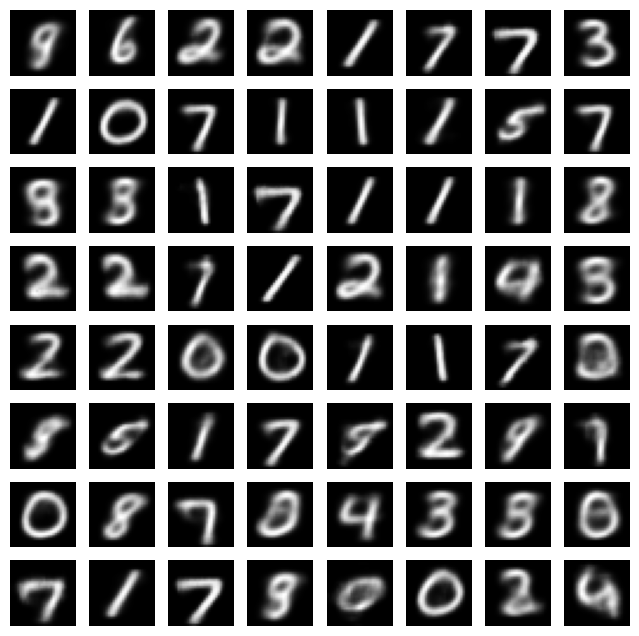

In [229]:
z = torch.randn(64, latent_dim).to(device)
samples = model.decoder_pass(z)

# Plot the generated images
fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(samples[i*8+j].view(28, 28).cpu().detach().numpy(), cmap='gray')
        ax[i, j].axis('off')

# plt.show()
plt.savefig('cvae_mnist.webp')

In [303]:
# encode and plot the z values for the train set 
model.eval()
z_all = []
y_all = []
pred_y_all = []

with torch.no_grad():
    for data, target in tqdm(test_loader, desc='Encoding'):
        data = data.view((-1,1,28,28)).to(device)
        mu, logvar, z, labels = model.half_pass(data)
        z_all.append(mu.cpu().numpy())
        y_all.append(np.argmax(target[:,0, 0:10].cpu().numpy(), axis=1))
        pred_y_all.append(np.argmax(labels[:, 0:10].cpu().numpy(), axis=1))

z_all = np.concatenate(z_all, axis=0)
y_all = np.concatenate(y_all, axis=0)
pred_y_all = np.concatenate(pred_y_all, axis=0)

Encoding:   0%|          | 0/40 [00:00<?, ?it/s]

In [304]:
from collections import defaultdict

data_centroids_dict = defaultdict(list)

for mu, y in zip(z_all, pred_y_all):
    data_centroids_dict[y].append(mu)

cluster_centroids_from_data = []

for numb in range(0,10):
    cluster_centroids_from_data.append(np.mean(data_centroids_dict[numb], axis=0))


cluster_centroids_from_data

[array([-0.4, -0.1, -0.1,  0.9,  0. ,  0.6], dtype=float32),
 array([-0.3,  0.2,  0.5, -0.9, -0. , -0.3], dtype=float32),
 array([ 0. ,  0.3,  0.9,  0.2, -0. , -0.2], dtype=float32),
 array([ 0.1, -0.7,  0.4,  0.3,  0. , -0.3], dtype=float32),
 array([ 0.4,  0.3, -0.7,  0. ,  0. ,  0. ], dtype=float32),
 array([ 0.1, -0.3,  0. ,  0.1,  0. ,  0.2], dtype=float32),
 array([-0.1,  1. ,  0.1,  0.5, -0. , -0.1], dtype=float32),
 array([-0.2, -0.4, -0.8, -0.6, -0. ,  0. ], dtype=float32),
 array([ 0.4, -0.3,  0. ,  0. , -0. ,  0. ], dtype=float32),
 array([ 0.2,  0. , -0.6, -0.1,  0. , -0.2], dtype=float32)]

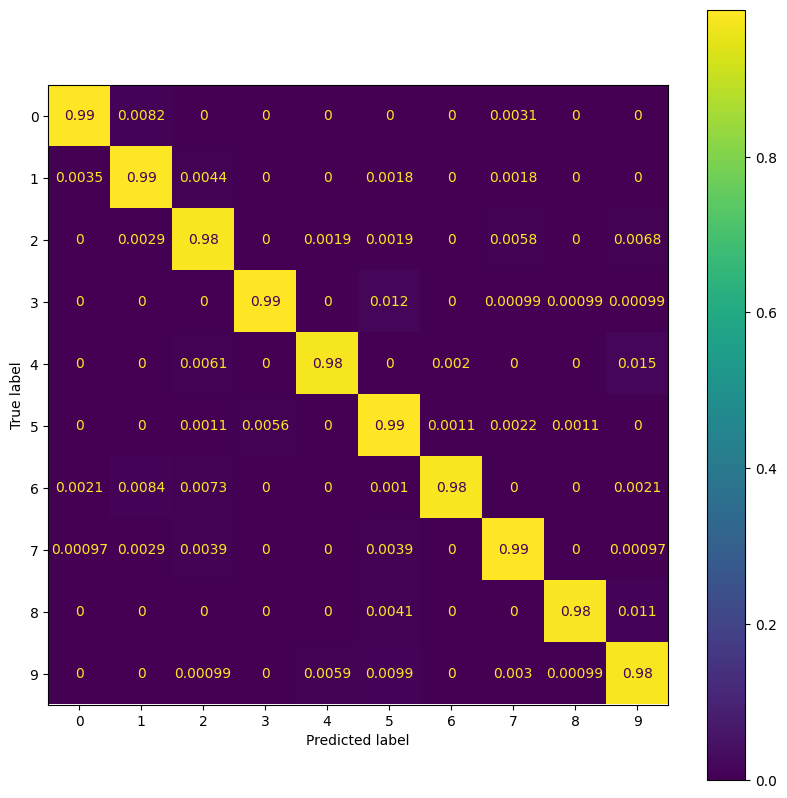

In [305]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_all, pred_y_all, normalize='true')
cmd = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize = (10, 10))
cmd.plot(ax=ax)

In [318]:
unique = list(set(range(fuzzy_labels)))
colors = [plt.cm.tab10(float(i)/max(unique)) for i in unique]

def class_scatter(ax, x1, x2, y, x_label, y_label, title, **kwargs):    
    for i, u in enumerate(unique):
        x1i = [x1[j] for j in range(len(x1)) if y[j] == u]
        x2i = [x2[j] for j in range(len(x2)) if y[j] == u]
        ax.scatter(x1i, x2i, c=colors[i], label=str(u), **kwargs)
    ax.legend()
    if ax is plt:
        ax.xlabel(x_label)
        ax.ylabel(y_label)
        ax.title(title)
    else:
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.set_title(title)


/tmp/ipykernel_7316/1012742646.py:8: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x1i, x2i, c=colors[i], label=str(u), **kwargs)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


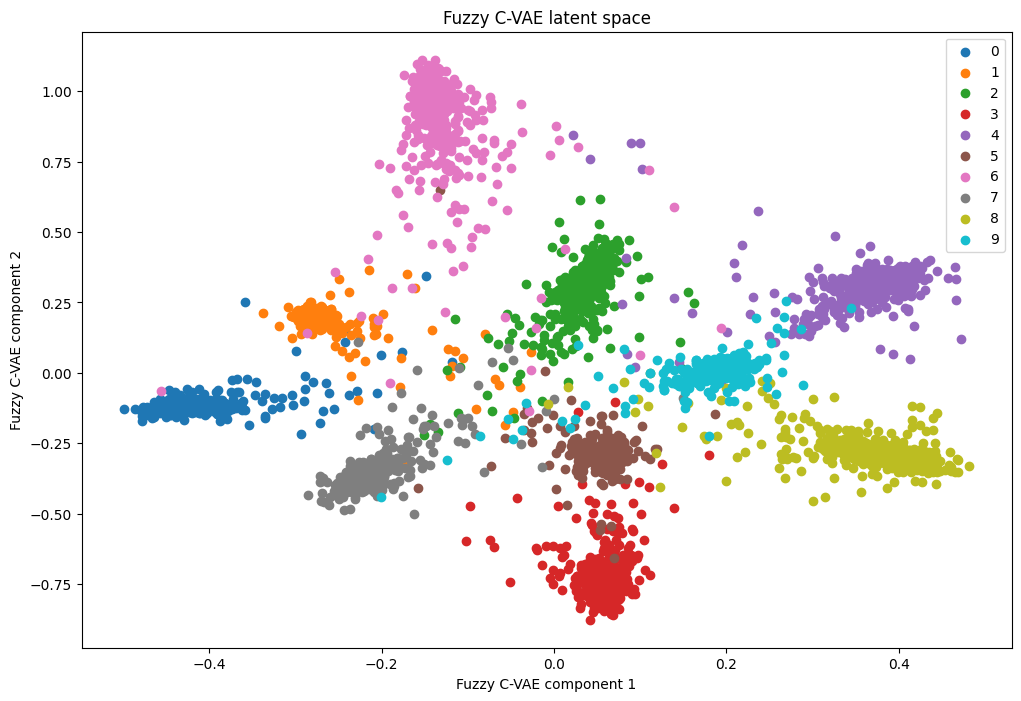

In [326]:
mask = "Fuzzy C-VAE"
if not is_fuzzy_loss_active:
    mask = "VAE"

plt.figure(figsize=(12, 8))
class_scatter(plt, z_all[:, 0], z_all[:, 1], y_all, f"{mask} component 1", f"{mask} component 2", f'{mask} latent space')
save_path = './papers/iiti24/fig2b-fcvae-all-features.eps' if is_fuzzy_loss_active else './papers/iiti24/fig2a-vae-all-features.eps'
plt.savefig(save_path, format='eps')

In [320]:
domains_scatter_points = []
for x in np.linspace(-1.9, 2.0, 200):
    for y in np.linspace(-1.2, 2, 200):
        fuzzy_inference = model.output.forward(torch.FloatTensor([[x,y]]).to(device)).cpu().detach().numpy()
        fuzzy_class =np.argmax(fuzzy_inference[0,0:10])
        domains_scatter_points.append([x,y,fuzzy_class])

domains_scatter_points = np.array(domains_scatter_points)

/tmp/ipykernel_7316/1012742646.py:8: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x1i, x2i, c=colors[i], label=str(u), **kwargs)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


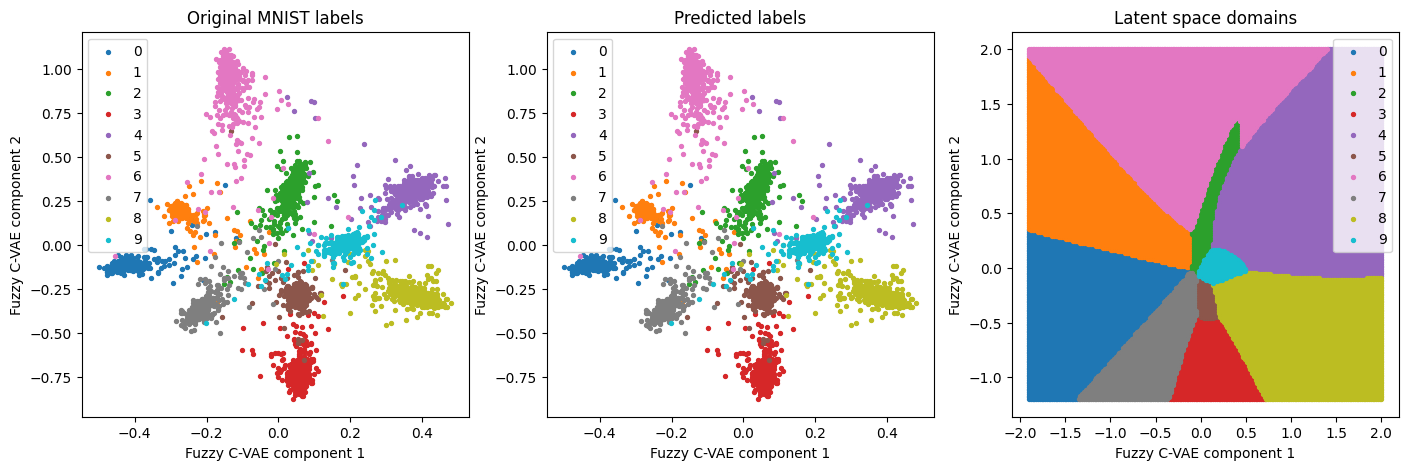

In [327]:
import matplotlib.colors
figure, axis = plt.subplots(1, 3, figsize=(17, 5)) 

class_scatter(axis[0], z_all[:, 0], z_all[:, 1], y_all, f"{mask} component 1", f"{mask} component 2", f'Original MNIST labels', s=8)
class_scatter(axis[1], z_all[:, 0], z_all[:, 1], y_all, f"{mask} component 1", f"{mask} component 2", f'Predicted labels', s=8)
class_scatter(axis[2], *domains_scatter_points.T, f"{mask} component 1", f"{mask} component 2", f'Latent space domains', s=8)

if is_fuzzy_loss_active:
    figure.savefig('./papers/iiti24/fig3-fcvae-classification.eps', format="eps", transparent=False)
plt.show()

## Data generation

torch.Size([10, 2])


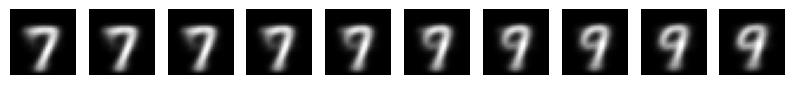

In [104]:
n = 10
path_from_4_to_9 = np.linspace(cluster_centroids_from_data[7], cluster_centroids_from_data[9], n)
path_from_4_to_9 = [torch.FloatTensor(a) for a in path_from_4_to_9]

z = torch.stack(path_from_4_to_9, dim=0).to(device)
print(z.shape)
samples = model.decoder_pass(z)
samples = torch.sigmoid(samples)

# Plot the generated images
fig, ax = plt.subplots(1, n, figsize=(n, 1))
for i in range(n):
    ax[i].imshow(samples[i].view(28, 28).cpu().detach().numpy(), cmap='gray')
    ax[i].axis('off')
    
plt.savefig('papers/iiti24/fig4-sample-generation.eps', format="eps")
plt.show()


tensor([[1.4558, 0.0209]], device='cuda:0', grad_fn=<SplitBackward0>)
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


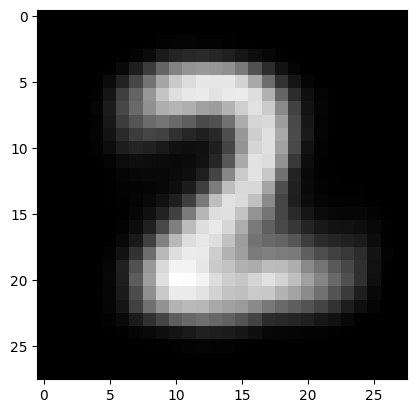

In [105]:

mu, std, z, fz = model.half_pass(test_data[1][0].reshape((1,1,28,28)).to(device))

# mu[0][0] = -2.8242958
# mu[0][1] = -0.39727297

print(mu)
np.set_printoptions(precision=1)
np.set_printoptions(suppress=True)
print(fz.cpu().detach().numpy())
samples = model.decoder_pass(mu)
#samples = torch.sigmoid(samples)
plt.imshow(samples[0].view(28, 28).cpu().detach().numpy(), cmap='gray')
    

## Anomaly detection

In [72]:
emnist_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.view(-1, 28, 28) - 0.5),
])

In [73]:
import pandas as pd

emnist_test = pd.read_csv("./data/EMNIST/emnist-letters.csv")
emnist_y = emnist_test["label"]
emnist_x = emnist_test.drop(labels = ["label"], axis = 1) 
del emnist_test 

emnist_x = emnist_x / 255.0
emnist_x = emnist_x.values.reshape(-1, 28, 28)
emnist_x = [torch.tensor(emnist_transform(a), dtype=torch.float32) for a in emnist_x]

len(emnist_x)

FileNotFoundError: [Errno 2] No such file or directory: './data/EMNIST/emnist-letters.csv'

In [29]:
emnist_mapping = pd.read_csv("./data/EMNIST/emnist-letters-mapping.txt", sep=' ', header=None)
emnist_mapping.columns=("EMNIST","UP","LO")
emnist_mapping["Letter"] = emnist_mapping.apply(lambda row: chr(row["UP"])+chr(row["LO"]), axis=1)
emnist_mapping = dict(zip(emnist_mapping["EMNIST"], emnist_mapping["Letter"]))
emnist_mapping

{1: 'Aa',
 2: 'Bb',
 3: 'Cc',
 4: 'Dd',
 5: 'Ee',
 6: 'Ff',
 7: 'Gg',
 8: 'Hh',
 9: 'Ii',
 10: 'Jj',
 11: 'Kk',
 12: 'Ll',
 13: 'Mm',
 14: 'Nn',
 15: 'Oo',
 16: 'Pp',
 17: 'Qq',
 18: 'Rr',
 19: 'Ss',
 20: 'Tt',
 21: 'Uu',
 22: 'Vv',
 23: 'Ww',
 24: 'Xx',
 25: 'Yy',
 26: 'Zz'}

In [30]:
model.eval()

anomaly_mu = defaultdict(list)


with torch.no_grad():
    for data, label in zip(emnist_x, emnist_y):
        data = data.view((-1,1,28,28)).to(device)
        mu, x_recon, flabels= model.forward(data)
        
        anomaly_mu[emnist_mapping[label]].append(mu.cpu().numpy())

anomaly_mu

defaultdict(list,
            {'Aa': [array([[-0.1, -0.6]], dtype=float32),
              array([[-0.4,  0.5]], dtype=float32),
              array([[-0.7, -0.9]], dtype=float32),
              array([[-1.4, -0.2]], dtype=float32),
              array([[ 0.2, -1.3]], dtype=float32),
              array([[-0.3,  0.1]], dtype=float32),
              array([[-0. , -0.9]], dtype=float32),
              array([[-0.1, -0.8]], dtype=float32),
              array([[-0.2, -1.1]], dtype=float32),
              array([[-0.4,  0.3]], dtype=float32),
              array([[-0.6,  0.6]], dtype=float32),
              array([[-0. , -0.9]], dtype=float32),
              array([[-1.6, -0.2]], dtype=float32),
              array([[-0.8, -0.1]], dtype=float32),
              array([[-0.4,  0.6]], dtype=float32),
              array([[-0.2, -0.8]], dtype=float32),
              array([[-0.1, -1.1]], dtype=float32),
              array([[-0.6,  0.4]], dtype=float32),
              array([[-0.2, -1.3]], dtyp

In [53]:
from sklearn.ensemble import IsolationForest

detectors = {}

if is_fuzzy_loss_active:
    for numb in range(0,10):
        isolf = IsolationForest(n_estimators=100, max_samples='auto', contamination='auto', max_features=1.0)
        isolf.fit(data_centroids_dict[numb])
        detectors[numb] = isolf
else:
    isolf = IsolationForest(n_estimators=100, max_samples='auto', contamination='auto', max_features=1.0)
    isolf.fit(z_all)
    detectors[0] = isolf

anomaly_rates = {}
for letters_pair in emnist_mapping.values():
   
    input = np.reshape(anomaly_mu[letters_pair],(len(anomaly_mu[letters_pair]),2))

    if is_fuzzy_loss_active:
        scores = [detectors[a].predict(input) for a in detectors.keys()]
        overall_score = np.max(scores,axis = 0)
        overall_score = [1 if a==-1 else 0 for a in overall_score]
        anomaly_rates[letters_pair] = (np.mean(overall_score), np.std(overall_score))
    else:
        scores = detectors[0].predict(input)
        overall_score = [1 if a==-1 else 0 for a in scores]
        anomaly_rates[letters_pair] = (np.mean(overall_score), np.std(overall_score))


In [54]:
scores = [detectors[a].predict(z_all) for a in detectors.keys()]

numbers_score = np.max(scores,axis = 0)
numbers_score = [1 if a==-1 else 0 for a in numbers_score]

print(f"Anomality rate on pure numbers {np.mean(numbers_score)}" )

Anomality rate on pure numbers 0.3151


In [55]:
anomaly_stats = []

anomaly_stats.append(
    {
            'Letters': '0123456789',
            'Detected anomaly rate': np.mean(numbers_score),
    }
)

for k in anomaly_rates.keys():
    anomaly_stats.append(
        {
            'Letters': k,
            'Detected anomaly rate': anomaly_rates[k][0],
        }
    )


pd.DataFrame(anomaly_stats).sort_values('Detected anomaly rate')

,Letters,Detected anomaly rate
13,Mm,0.007139
23,Ww,0.008764
25,Yy,0.079351
6,Ff,0.080830
16,Pp,0.111584
18,Rr,0.131548
21,Uu,0.142147
22,Vv,0.148451
20,Tt,0.157742
24,Xx,0.199302


In [56]:
latex_table = pd.DataFrame(anomaly_stats, index=None).sort_values('Detected anomaly rate').to_latex( escape = False,index=False, float_format="{:.2f}".format)
print(latex_table)

\begin{tabular}{lr}
\toprule
Letters & Detected anomaly rate \\
\midrule
Mm & 0.01 \\
Ww & 0.01 \\
Yy & 0.08 \\
Ff & 0.08 \\
Pp & 0.11 \\
Rr & 0.13 \\
Uu & 0.14 \\
Vv & 0.15 \\
Tt & 0.16 \\
Xx & 0.20 \\
Hh & 0.23 \\
Nn & 0.24 \\
Ii & 0.24 \\
Kk & 0.29 \\
0123456789 & 0.32 \\
Ll & 0.33 \\
Jj & 0.42 \\
Aa & 0.47 \\
Gg & 0.54 \\
Ee & 0.55 \\
Bb & 0.61 \\
Qq & 0.61 \\
Ss & 0.63 \\
Dd & 0.64 \\
Zz & 0.79 \\
Cc & 0.83 \\
Oo & 0.91 \\
\bottomrule
\end{tabular}



tensor([0.3097, 0.2051, 0.5315, 0.3188, 0.2251, 0.8330, 0.2817, 0.3149, 0.2397,
        0.1616], device='cuda:0')
tensor(0.8330, device='cuda:0')


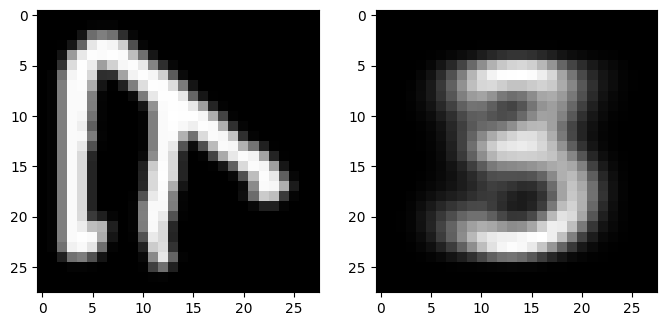

In [45]:
model.eval()

with torch.no_grad():
    fig, ax = plt.subplots(1, 2, figsize=(8, 8))
    data = emnist_x[4009]
    data = data.view((-1,1,28,28)).to(device)
    mu, x_recon, flabels= model.forward(data)
    print(flabels[0])
    print(flabels[0][0:10].max())
    ax[0].imshow(data.view(28, 28).cpu().detach().numpy(), cmap='gray')
    ax[1].imshow(x_recon.view(28, 28).cpu().detach().numpy(), cmap='gray')